# Global indicator project - Phoenix, Arizona
This notebook is created to replicate some analysis processes from the Bangkok project. Could be usefule for visualization and later indcator discussion.

In [1]:
# Libraries used for OSMnx analyses and output
import networkx as nx
import time 
import osmnx as ox
import matplotlib.pyplot as plt
import numpy as np
import requests
import fiona
import pandas as pd
import geopandas as gpd

from descartes import PolygonPatch
from shapely.geometry import shape,Point, LineString, Polygon

import config

ox.config(use_cache=True, log_console=True)
ox.__version__

'0.9'

In [2]:
suffix = '_201905'

places = ['Phoenix, Arizona, USA']

## Clean intersections - for street connectivity?

Note: this code is adopted from 'OSMNX intersection tuning.ipynb'

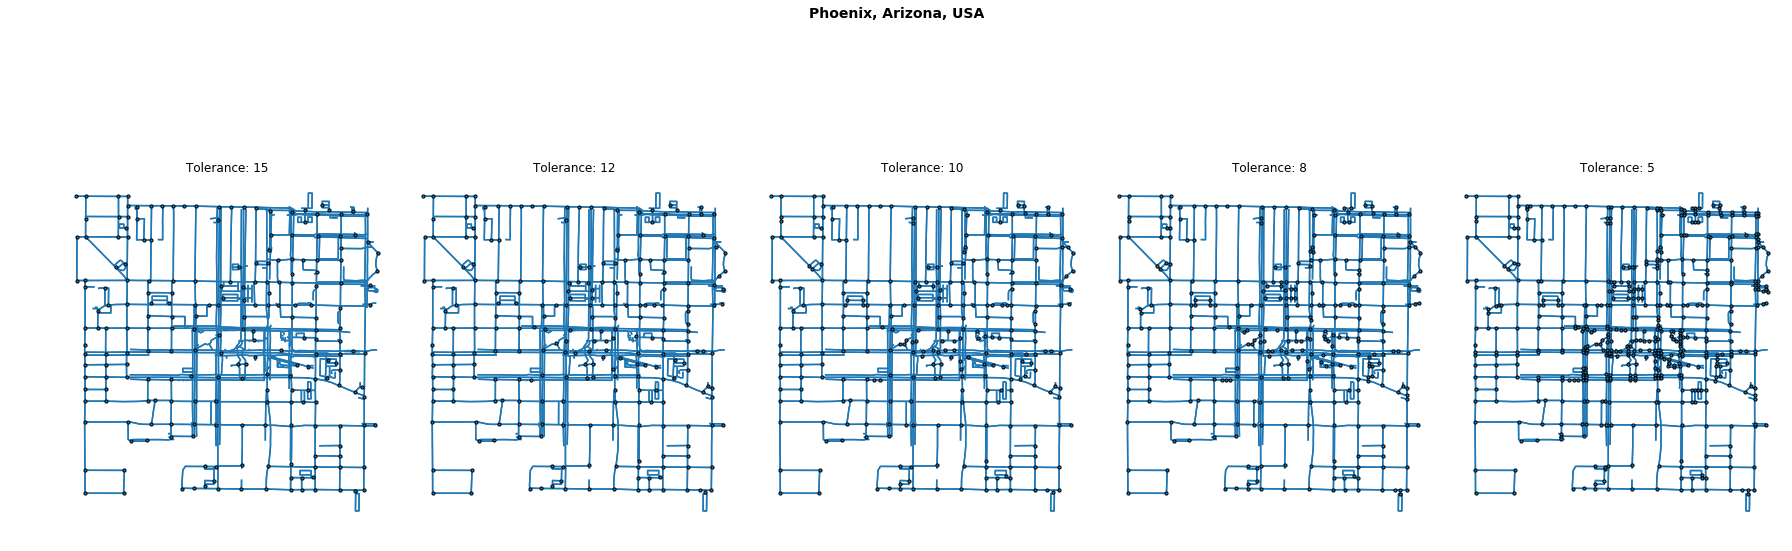

In [3]:
def OSM_clean_intersection(address):
    G = ox.graph_from_address(address, network_type= 'walk', distance=750)
    G_proj = ox.project_graph(G)
    G_proj_gdfs = ox.graph_to_gdfs(G_proj, nodes=False, edges=True, fill_edge_geometry=True)
    #itereate over cleaning buffer distance
    buffers = [15,12,10,8,5]
    # instantiate plot
    fig, axarr = plt.subplots(ncols=5, sharex='col', sharey='row', squeeze=False, figsize=(25,10))
    for i in range(len(buffers)):
        # clean up the intersections and extract their xy coords
        intersections = ox.clean_intersections(G_proj, tolerance=buffers[i], dead_ends=False)
        points = np.array([point.xy for point in intersections])
        # plot the cleaned-up intersections
        G_proj_gdfs.plot(ax = axarr[0][i])
        axarr[0][i].scatter(x=points[:,0], y=points[:,1], s = 10, zorder=2, color=None, edgecolors='#000000')
        axarr[0][i].set_title("Tolerance: {}".format(buffers[i]))
        axarr[0][i].set_aspect(1)
        axarr[0][i].set_axis_off()
        # axarr[0][i].add_patch(patches.Rectangle((0.8, 0.8), 0.2, 0.2))
    plt.suptitle(address, fontsize=14, fontweight='bold')    
    plt.tight_layout()
    plt.show()
    return intersections

for address in places:
    OSM_clean_intersection(address)

Idea (from Carl): Could be interesting to overlay modified tolerances with some kind of image difference overlay relative to original (e.g. colourize where nodes have been added or subtracted)

## Study region isochrone map - for local walkability and OD analysis
Carl: ch_custom_routing_20180824.ipynb - from August last year when I was trialling calculation of sausage buffers (which we use for calculating local walkability) and OD analysis

In [2]:
place = 'Phoenix, Arizona, USA'
trip_times = [5, 10, 15, 20, 25] #in minutes
travel_speed = 4.5 #walking speed in km/hour

In [3]:
# load street network graph
Phx = ox.load_graphml('{studyregion}_walk{suffix}.graphml'.format(studyregion = place, suffix = config.time), folder = config.OSM_data_loc)
## the current street network is not projected, should we project the graph?

In [4]:
# Specify a point at which we want to get a local area network
orig_point = (33.64048784, -111.9860407) #example of a metro stop in Phx
orig_node = ox.get_nearest_node(Phx, orig_point)

## get local portion of a graph based on coordinate
nh3200m = nx.ego_graph(Phx, orig_node, radius=3200, distance='length')

# find the centermost node and then project the graph to UTM
gdf_nodes = ox.graph_to_gdfs(nh3200m, edges=False)
x, y = gdf_nodes['geometry'].unary_union.centroid.xy
center_node = ox.get_nearest_node(nh3200m, (y[0], x[0]))
G_nh_proj = ox.project_graph(nh3200m)

# add an edge attribute for time in minutes required to traverse each edge
meters_per_minute = travel_speed * 1000 / 60 #km per hour to m per minute
for u, v, k, data in G_nh_proj.edges(data=True, keys=True):
    data['time'] = data['length'] / meters_per_minute


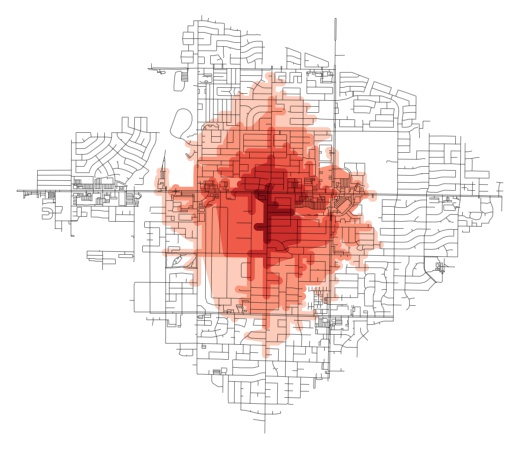

In [5]:
# plot isochrones as buffers to get more faithful isochrones
def make_iso_polys(G, edge_buff=25, node_buff=50, infill=False):
    isochrone_polys = []
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')
        node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
        nodes_gdf = gpd.GeoDataFrame({'id': subgraph.nodes()}, geometry=node_points)
        nodes_gdf = nodes_gdf.set_index('id')
        edge_lines = []
        for n_fr, n_to in subgraph.edges():
            f = nodes_gdf.loc[n_fr].geometry
            t = nodes_gdf.loc[n_to].geometry
            edge_lines.append(LineString([f,t]))
        n = nodes_gdf.buffer(node_buff).geometry
        e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) + list(e)
        new_iso = gpd.GeoSeries(all_gs).unary_union
        # try to fill in surrounded areas so shapes will appear solid and blocks without white space inside them
        if infill:
            new_iso = Polygon(new_iso.exterior)
        isochrone_polys.append(new_iso)
    return isochrone_polys

# get one color for each isochrone
iso_colors = ox.get_colors(n=len(trip_times), cmap='Reds', start=0.3, return_hex=True) 

isochrone_polys = make_iso_polys(G_nh_proj, edge_buff=50, node_buff=0, infill=True)
fig, ax = ox.plot_graph(G_nh_proj, fig_height=8, show=False, close=False, edge_color='k', edge_alpha=0.2, node_color='none')
for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
    ax.add_patch(patch)
    
plt.show()

### Create sausage buffer based on certain distance of walkable street network for entire city rather than neighborhood?

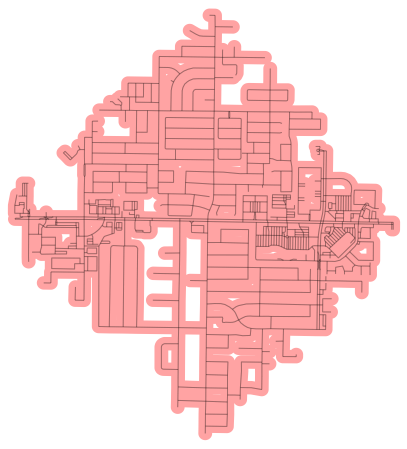

In [6]:
# define isochrone function using line instead of nodes.
def make_iso_polys(G, center_node, buffer=50, length = 1600):
    # could iterate over a list of center_nodes? or vectorize?
    # lengths = [1600]
    # iso_colors = ox.get_colors(n=1, cmap='Reds', start=0.3, return_hex=True)    
    # isochrone_polys = []
    # for length in sorted(lengths, reverse=True):
    subgraph = nx.ego_graph(G, center_node, radius=length, distance='length')
    su = ox.graph_to_gdfs(subgraph, nodes=False, edges=True, fill_edge_geometry=True)
    bu = su.geometry.buffer(buffer)
    uu = bu.geometry.unary_union
    return([subgraph,uu])


sausagebuffers = []
sausagebuffers.append(make_iso_polys(G_nh_proj, center_node = orig_node))

# plot figure
## get local portion of a graph based on coordinate

fig, ax = ox.plot_graph(sausagebuffers[0][0], 
                        fig_height=8, 
                        show=False, 
                        close=False,
                        edge_color='k', 
                        edge_alpha=0.2, 
                        node_color='none')

patch = PolygonPatch(sausagebuffers[0][1], fc='#FF6666', ec='none', alpha=0.6, zorder=-1)
ax.add_patch(patch)
plt.show()
